In [1]:
%%capture
!pip install liac-arff

In [2]:
import pandas as pd
from scipy.io import arff
from scipy import stats
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from tensorflow import keras
from sklearn.model_selection import train_test_split

## Data Reading

In [3]:
filePath="/content/drive/MyDrive/try/BasserahAssisment/Credit_Dataset.arff"

In [4]:
data, meta = arff.loadarff(filePath)
# Convert the data into a Pandas DataFrame
df = pd.DataFrame(data)
# Decode byte-encoded values using applymap and lambda function
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
# Display the first few rows of the DataFrame
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


## First impression

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [6]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [7]:
df["checking_status"].value_counts()

no checking    394
<0             274
0<=X<200       269
>=200           63
Name: checking_status, dtype: int64


**Meaning**

    'no checking': This category indicates that the applicant does not have an existing checking account or that the status of their checking account is not applicable or cannot be determined.

    '<0': This category implies that the balance in the checking account is less than 0, suggesting a negative balance or an overdraft situation where the account holder has exceeded their available funds.

    '0<=X<200': This category suggests that the checking account balance falls within the range from 0 (inclusive) to 200 (exclusive) in some unit of currency, such as Deutsche Mark. This range signifies a relatively lower balance in the checking account.

    '>=200': This category indicates that the balance in the checking account is equal to or greater than 200, suggesting a higher balance or a more substantial amount of funds available in the account.

In [8]:
df["credit_history"].value_counts()

existing paid                     530
critical/other existing credit    293
delayed previously                 88
all paid                           49
no credits/all paid                40
Name: credit_history, dtype: int64

**Meaning**

    'existing paid': This category indicates that the applicant has a credit history where they have taken credits in the past and have paid them back duly. It implies a positive credit history with a track record of meeting credit obligations.

    'critical/other existing credit': This category suggests that the applicant's credit history includes critical accounts or other existing credit with potential issues or delays in payments. It signifies a less favorable credit history.

    'delayed previously': This category indicates that the applicant has a history of delayed payments on credit accounts. It implies a credit history with past instances of payment delays.

    'all paid': This category suggests that the applicant has successfully paid back all previous credits. It implies a positive credit history with no outstanding debts or defaults.

    'no credits/all paid': This category indicates that the applicant has no previous credits or debts, but if they had any, they have been paid back duly. It implies a lack of significant credit history.

In [9]:
df["savings_status"].value_counts()

<100                603
no known savings    183
100<=X<500          103
500<=X<1000          63
>=1000               48
Name: savings_status, dtype: int64

**Meaning**

    '<100': This category indicates that the savings account balance or the value of the bonds falls below 100 in the currency unit mentioned in the dataset, likely Deutsche Mark. This range suggests a relatively low savings balance.

    'no known savings': This category implies that the applicant does not have a known or specified savings account or bond information, indicating a lack of information about their savings status.

    '100<=X<500': This category suggests that the savings account balance or the value of the bonds falls within the range from 100 (inclusive) to 500 (exclusive) in the specified currency unit. It signifies a moderate savings balance.

    '500<=X<1000': This category indicates that the savings account balance or the value of the bonds falls within the range from 500 (inclusive) to 1000 (exclusive) in the specified currency unit. It suggests a relatively higher savings balance.

    '>=1000': This category suggests that the savings account balance or the value of the bonds is equal to or greater than 1000 in the specified currency unit, indicating a substantial savings balance.

## So we now can define the featuers in the data as following
  **checking_status**: Status of existing checking account in Deutsche Mark, representing the current status of the customer's checking account. **duration**: Duration of the credit in months, indicating the length of time for which the credit is extended.\
  **credit_history**: Credit history, reflecting the past credit behavior of the customer, including credits taken, paid back duly, delays, and critical accounts.\
   **purpose**: Purpose of the credit, describing the reason for which the credit is being taken (e.g., car, television, etc.).\
  **credit_amount**: Credit amount in Deutsche Mark, representing the total amount of credit being extended.\
   **savings_status**: Status of savings account/bonds in Deutsche Mark, indicating the status of the customer's savings or bonds account.\
  **employment**: Present employment in number of years, representing the length of the current employment of the customer.\
  **installment_commitment**: Installment rate in percentage of disposable income, showing the percentage of the customer's disposable income committed to paying installments.\
  **personal_status**: Personal status and sex, providing information about the marital status and gender of the customer.\
  **other_parties**: Other debtors/guarantors, indicating the involvement of other parties in the credit agreement.\
   **residence_since**: Present residence since X years, representing the duration of the customer's current residence.\
   **property_magnitude**: Property type or magnitude, such as real estate, providing information about the type of property owned by the customer.\
   **age**: Age in years, indicating the age of the customer.\
   **other_payment_plans**: Other installment plans, including those from other banks or stores.\
   **housing**: Housing status, indicating whether the customer rents or owns a house.\
   **existing_credits**: Number of existing credits at this bank, representing the number of other credits the customer currently has from the same bank.\
   **job**: Job type, providing information about the occupation or job of the customer.\
  **num_dependents**: Number of people being liable to provide maintenance for, representing the number of dependents the customer has.\
  **own_telephone**: Telephone status, indicating whether the customer has a telephone or not.\
  **foreign_worker**: Foreign worker status, indicating whether the customer is a foreign worker or not.\
  **class**: Credit classification, the response variable to be predicted, indicating whether the customer is classified as 'good' or 'bad' in terms of creditworthiness.

# **EDA**

### Univariante analysis

### Classifiy the featuers based on there types

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

In [11]:
numericalCols = [col for col in df.columns if len(df[f"{col}"].value_counts())>10]

In [12]:
categoricalCols = [col for col in df.columns if len(df[f"{col}"].value_counts())<=10]

In [13]:
numericalCols

['duration', 'credit_amount', 'age']

# Let's get insights from numerical cols

### Descriptive Statistics

In [14]:
for col in numericalCols:
    print(f"Statistics for {col}:")
    print("Mean:", df[col].mean())
    print("Median:", df[col].median())
    print("Mode:", df[col].mode().values[0])
    print("Standard Deviation:", df[col].std())
    print("Minimum Value:", df[col].min())
    print("Maximum Value:", df[col].max())
    print("")

Statistics for duration:
Mean: 20.903
Median: 18.0
Mode: 24.0
Standard Deviation: 12.058814452756375
Minimum Value: 4.0
Maximum Value: 72.0

Statistics for credit_amount:
Mean: 3271.258
Median: 2319.5
Mode: 1258.0
Standard Deviation: 2822.7368759604406
Minimum Value: 250.0
Maximum Value: 18424.0

Statistics for age:
Mean: 35.546
Median: 33.0
Mode: 27.0
Standard Deviation: 11.375468574317512
Minimum Value: 19.0
Maximum Value: 75.0



**Conclusion**

    Duration:
        The duration ranges from 4 to 72 months, with an average duration of approximately 20.9 months.
        The data appears to be positively skewed, as the mean is slightly higher than the median.
        The standard deviation of approximately 12.06 suggests that the data points are somewhat dispersed around the mean.

    Credit Amount:
        The credit amount ranges from 250 to 18,424, with an average credit amount of approximately 3,271.26.
        The data exhibits a larger spread, as indicated by the higher standard deviation of about 2,822.74.
        The distribution seems positively skewed, given that the mean is greater than the median.

    Age:
        The ages range from 19 to 75 years, with an average age of about 35.55 years.
        The data distribution appears to be relatively symmetric, with the mean and median being close in value.
        The standard deviation of approximately 11.38 suggests a moderate spread of the data points around the mean.

## Distribution Analysis

<ipython-input-15-924e87e9b104>:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x=df[numerical_column], ax=axes[1],palette="rocket")
<ipython-input-15-924e87e9b104>:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[numerical_column], kde=True, ax=axes[2],palette="rocket")


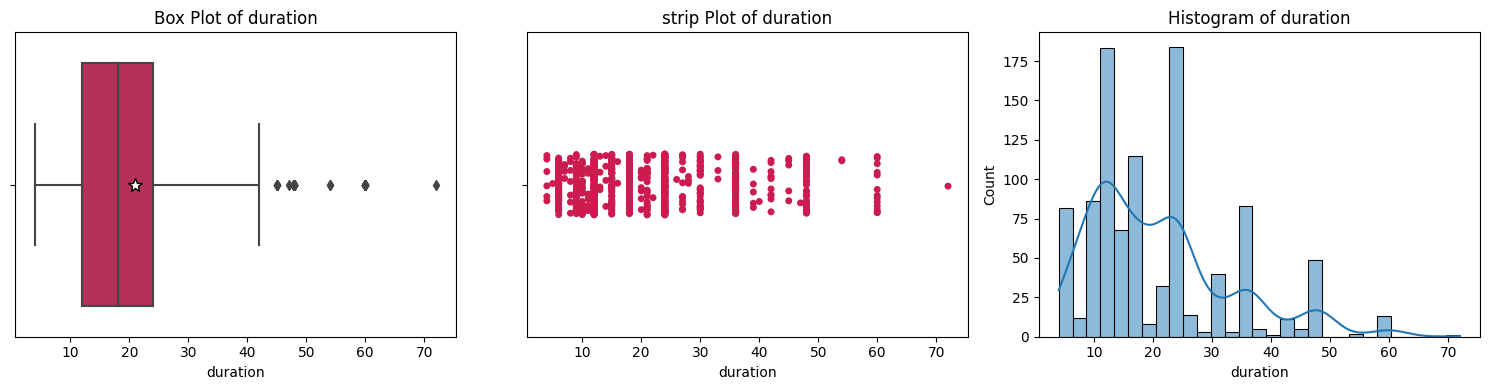

<ipython-input-15-924e87e9b104>:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x=df[numerical_column], ax=axes[1],palette="rocket")
<ipython-input-15-924e87e9b104>:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[numerical_column], kde=True, ax=axes[2],palette="rocket")


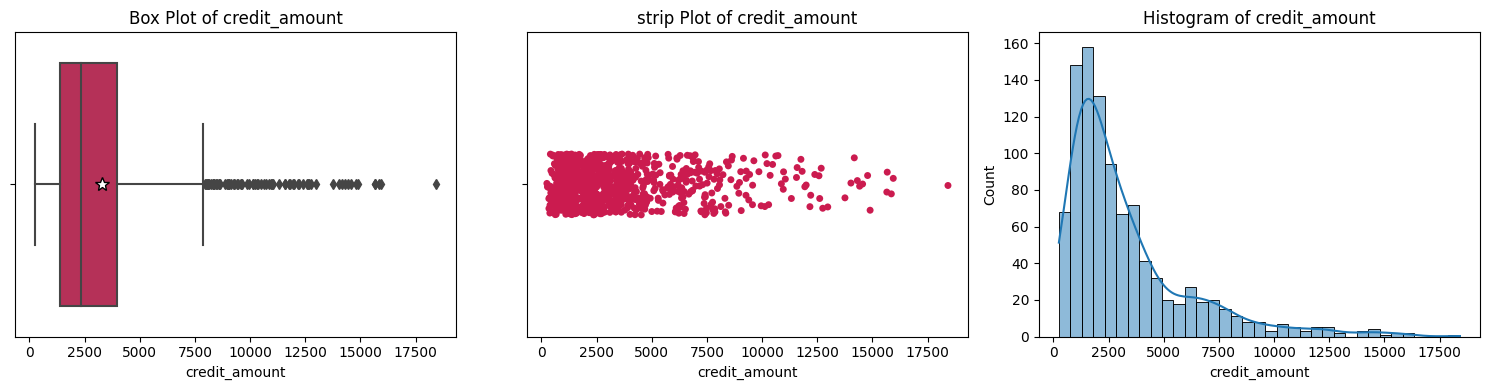

<ipython-input-15-924e87e9b104>:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x=df[numerical_column], ax=axes[1],palette="rocket")
<ipython-input-15-924e87e9b104>:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[numerical_column], kde=True, ax=axes[2],palette="rocket")


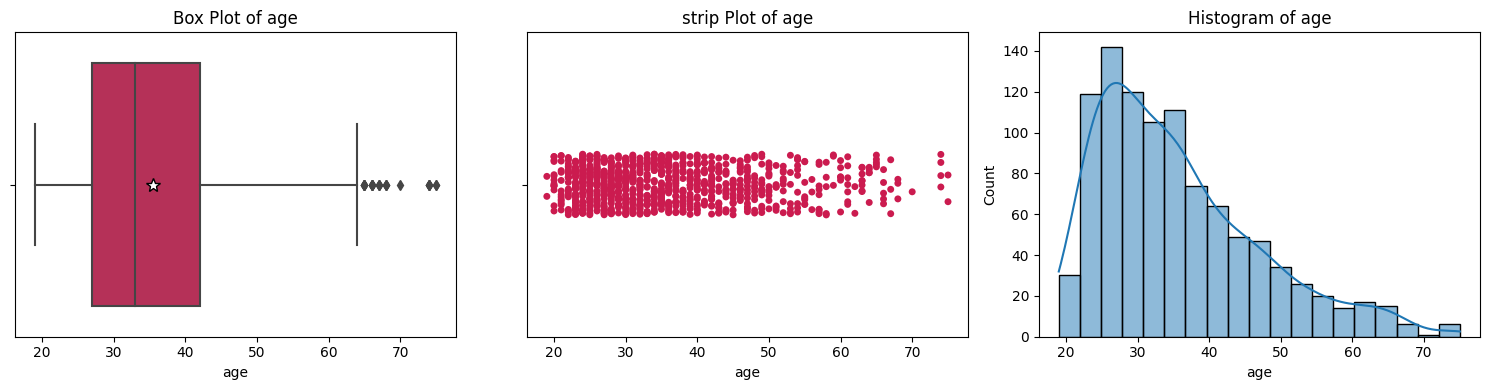

In [15]:
custom_palette = ["#FF9999", "#66B2FF"]
for col in numericalCols:
    numerical_column = col
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    # Box plot
    sns.boxplot(x=df[numerical_column], ax=axes[0],palette="rocket",showmeans=True,meanprops={"marker":"*",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10"})
    axes[0].set_title(f'Box Plot of {col}')
    # stripplot
    sns.stripplot(x=df[numerical_column], ax=axes[1],palette="rocket")
    axes[1].set_title(f'strip Plot of {col}')
    # Histogram
    sns.histplot(df[numerical_column], kde=True, ax=axes[2],palette="rocket")
    axes[2].set_title(f'Histogram of {col}')
    # Adjust layout
    plt.tight_layout()
    plt.show()

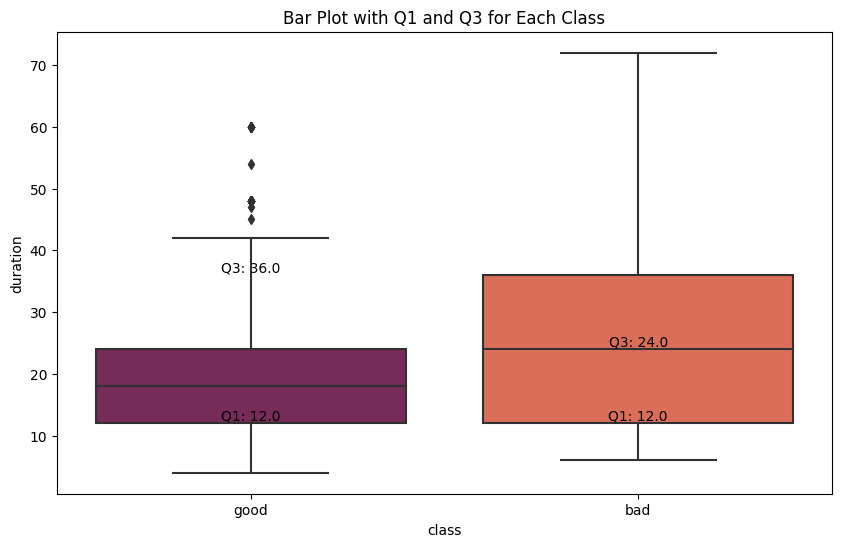

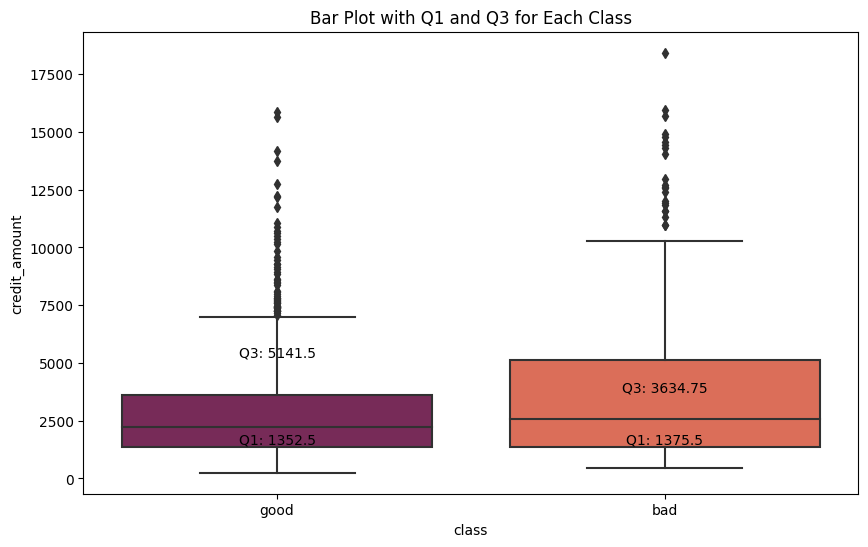

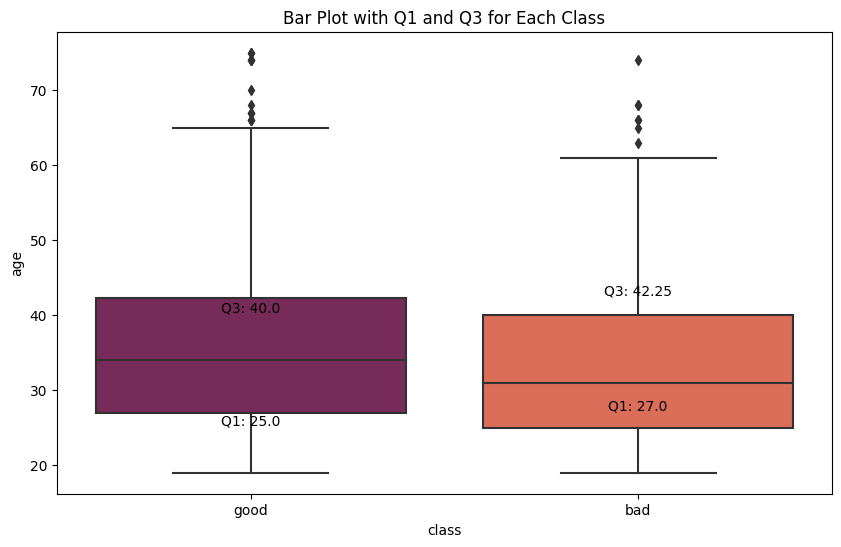

In [16]:
for col in numericalCols:
    x = "class" # The categorical variable
    y = col # The numerical variable

    # Calculate Q1 and Q3 for each class
    q1_values = df.groupby(x)[y].quantile(0.25)
    q3_values = df.groupby(x)[y].quantile(0.75)

    # Create a bar plot
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x=x, y=y, data=df,palette="rocket")

    # Annotate the bar plot with Q1 and Q3 for each class
    for i in range(len(q1_values.index)):
        plt.text(i, q1_values.iloc[i], f'Q1: {q1_values.iloc[i]}', ha='center', va='bottom', color='black')
        plt.text(i, q3_values.iloc[i], f'Q3: {q3_values.iloc[i]}', ha='center', va='bottom', color='black')

    # Add title and labels
    plt.title('Bar Plot with Q1 and Q3 for Each Class')
    plt.xlabel(x)
    plt.ylabel(col)

    # Show plot
    plt.show()

**conclusion**

    Duration:
         the duration ranging from 5 to 45 months provides a good distribution of data points.
         This range covers varying time periods, from approximately half a year to around 3.75 years,
         which can indeed aid in the decision-making process for determining whether a user can be granted credit.
         Note:
         there are some outlayers we need to handle them
    Credit Amount:
         credit_amount values within the 0 to 7500 range implies that the majority of the applicants fall within this credit limit.
         Outliers beyond 7500 may indicate cases with exceptionally high credit amounts,
         which could suggest individuals with significant financial stability or potentially greater financial risk.
         While individuals with access to higher credit amounts might have a high income,
         the variability in their income sources could pose a risk.
         Note:
         there are some outlayers we need to handle them
    Age:
        The ages are from the 20 to 75 so by this ranges we can do a good
        clasifcation since younger individuals might have a higher tendency to apply for credit


> **Note**


The age feature is not good to classify between the two classes while the remaing features are , for the duration if it's greater than 40 you can
make say that is classified as bad, while in amount is greaater than 7500 is classified as bad also

### Correlation Analysis

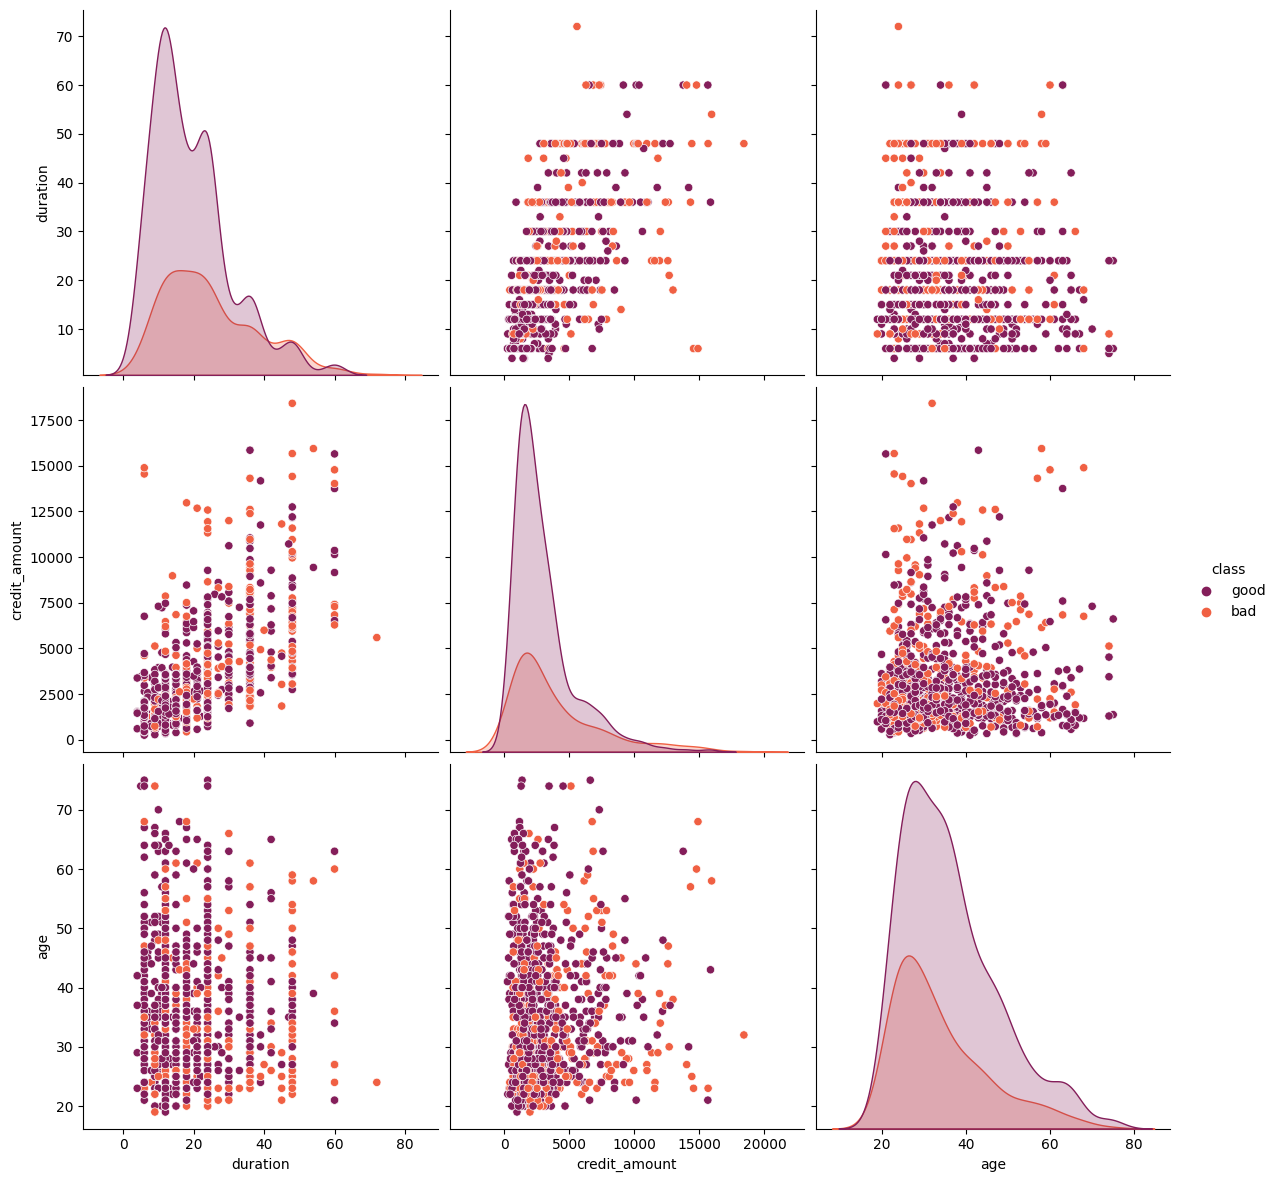

In [17]:
sns.pairplot(df[numericalCols+["class"]], hue="class", palette="rocket", diag_kind="kde", height=len(numericalCols)+1)

<Axes: >

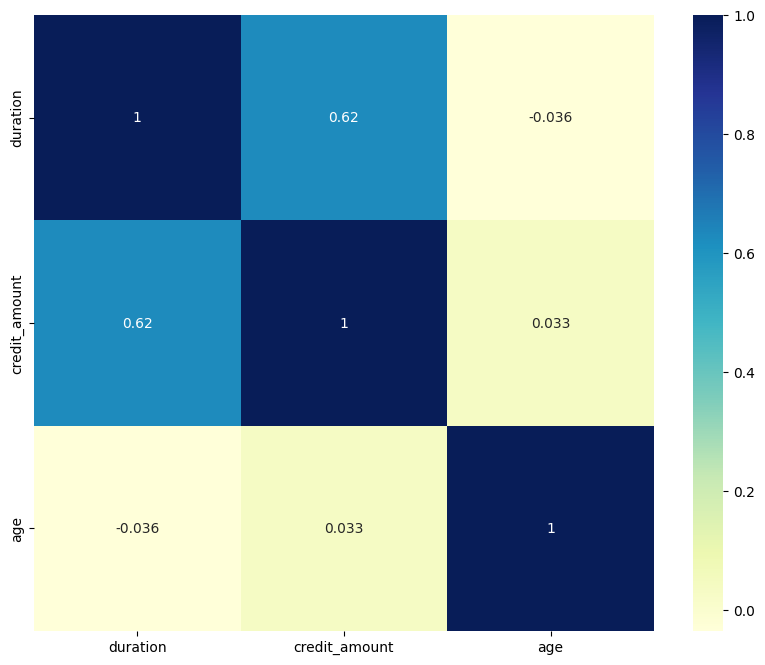

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numericalCols].corr(), annot=True, cmap="YlGnBu")

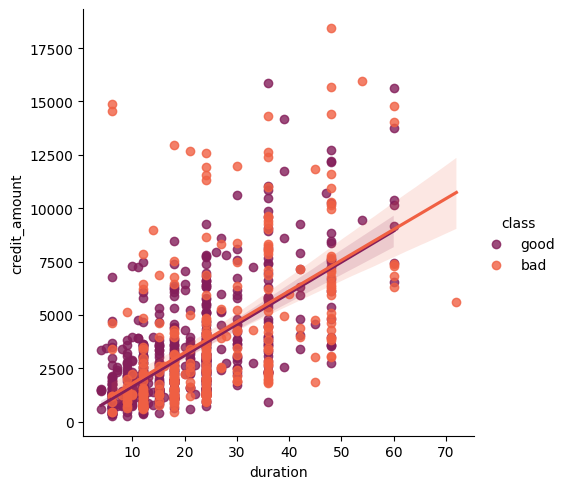

In [19]:
sns.lmplot(x="duration", y="credit_amount", data=df[numericalCols+["class"]],hue="class", palette="rocket")

**conclusion**

    Duration and credit amount is correlated featuers:
         There is an correlation between the duration and credit amount with value 0.62 which is meaning that indicates a moderately positive linear relationship between these two variables.
         A correlation coefficient of 0.62 suggests that as the 'duration' of the credit increases,
         there is a tendency for the 'credit_amount' to also increase, and vice versa.

# Let's get insights from categorical cols




In [20]:
categoricalCols

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'installment_commitment',
 'personal_status',
 'other_parties',
 'residence_since',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'existing_credits',
 'job',
 'num_dependents',
 'own_telephone',
 'foreign_worker',
 'class']

### Class Distribution

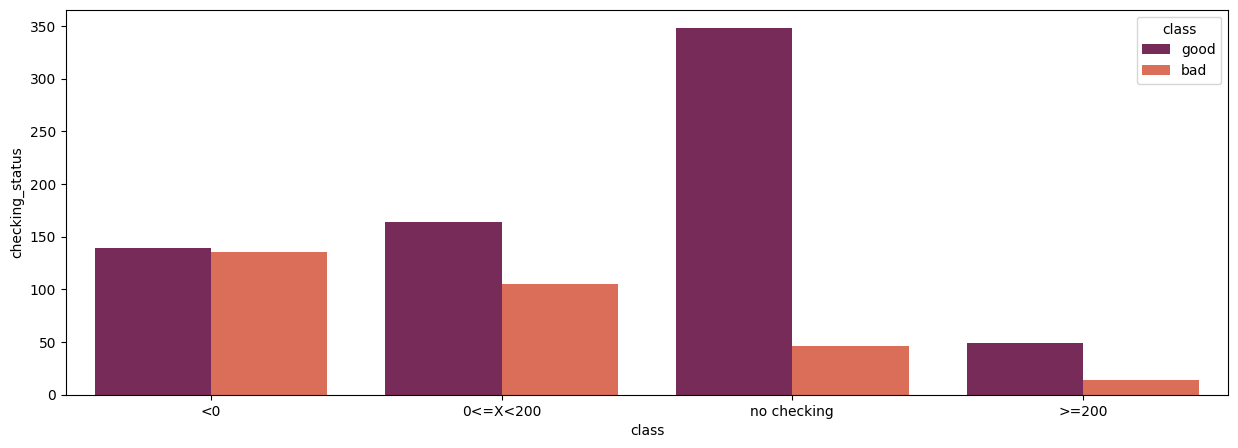

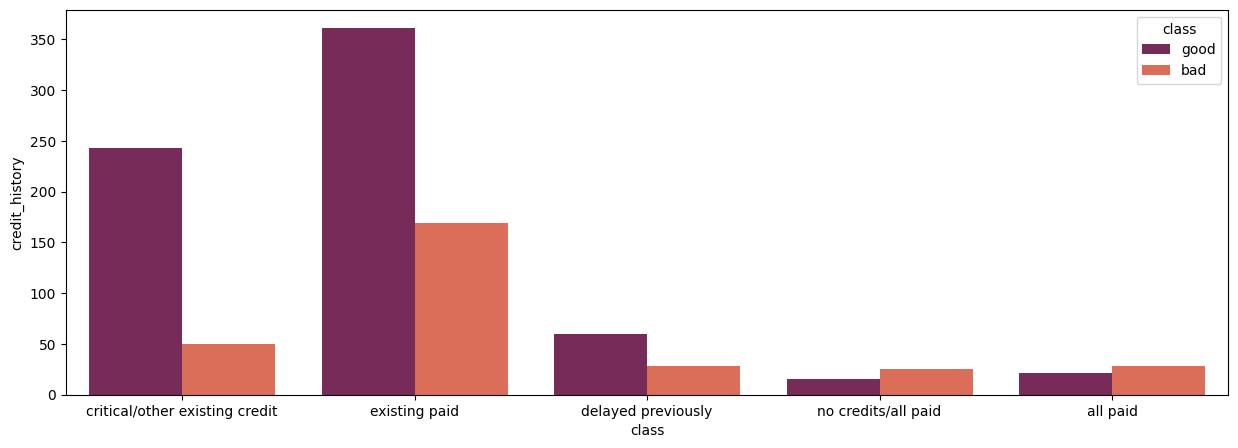

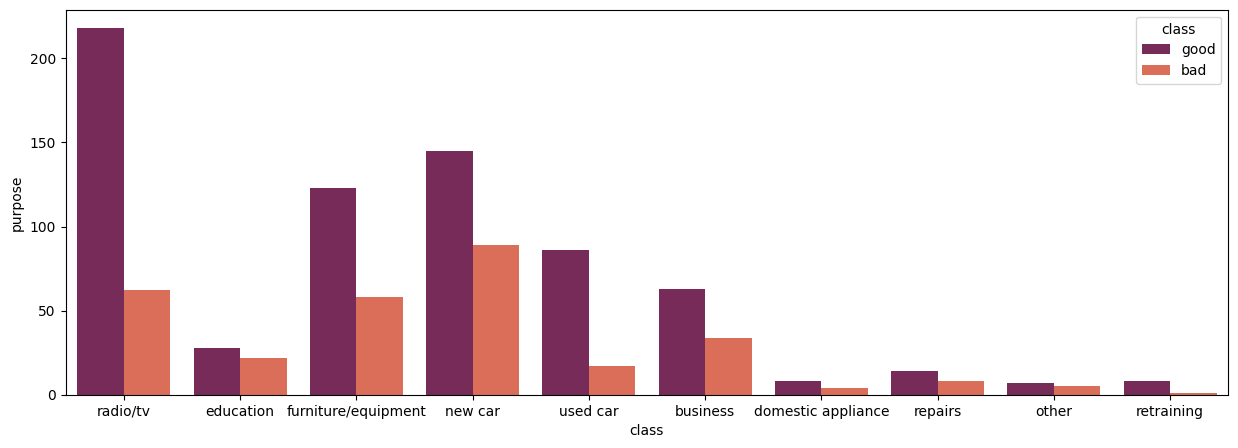

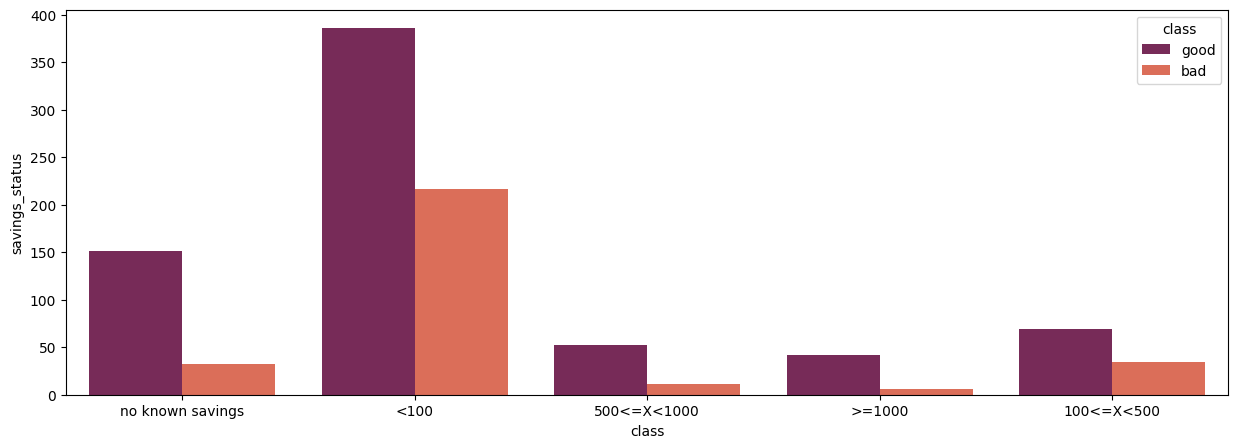

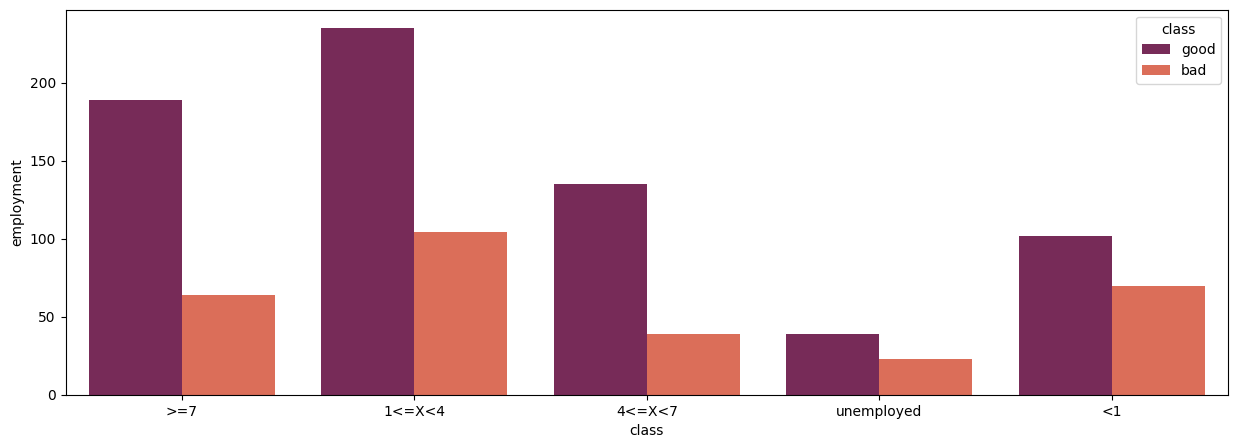

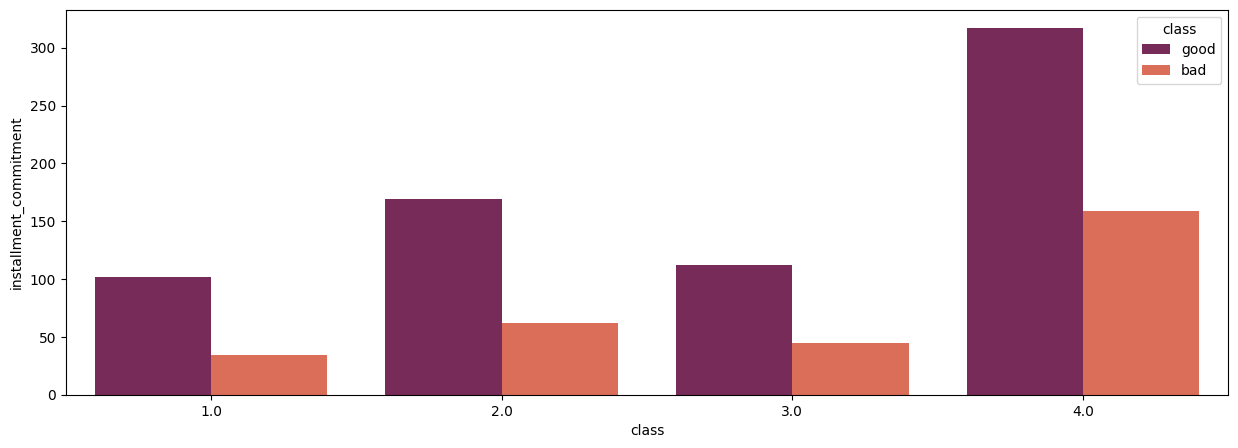

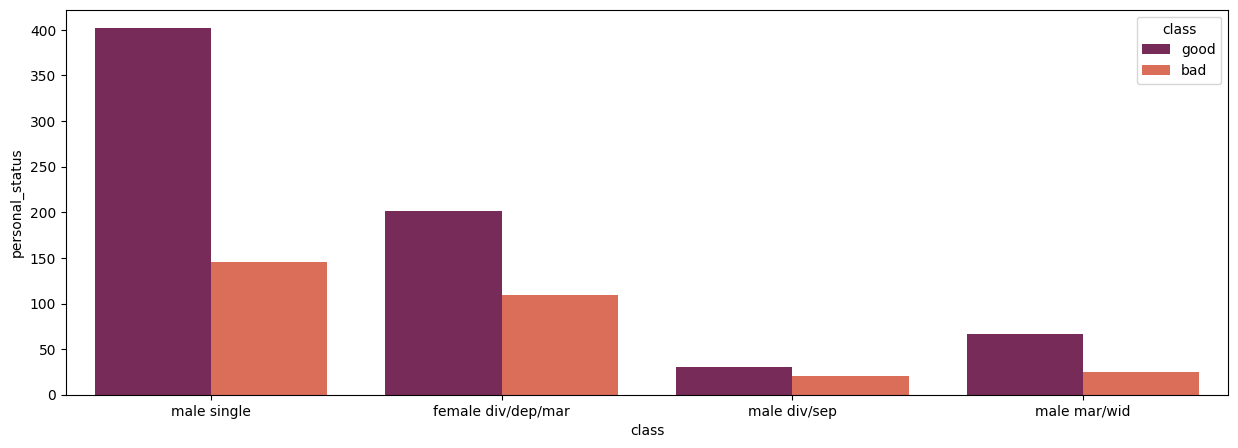

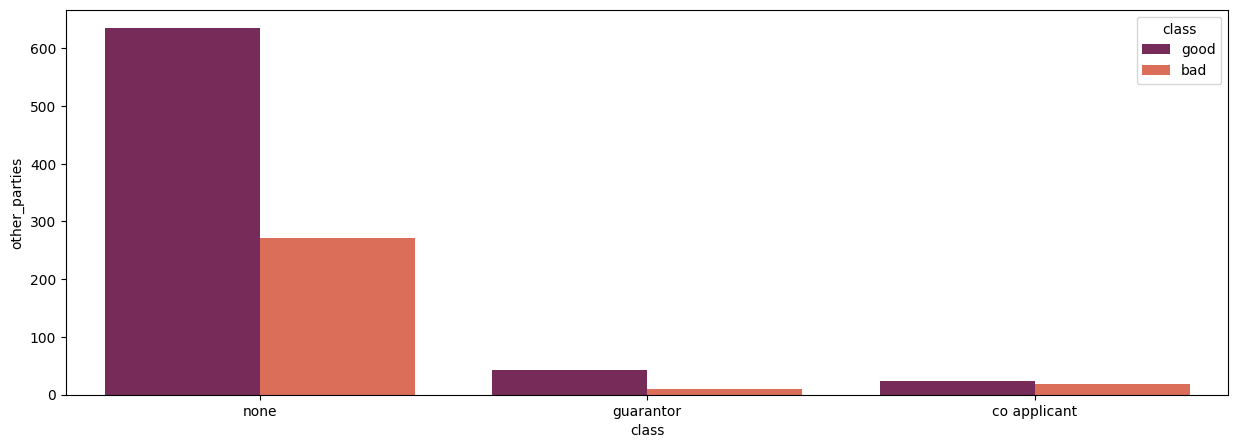

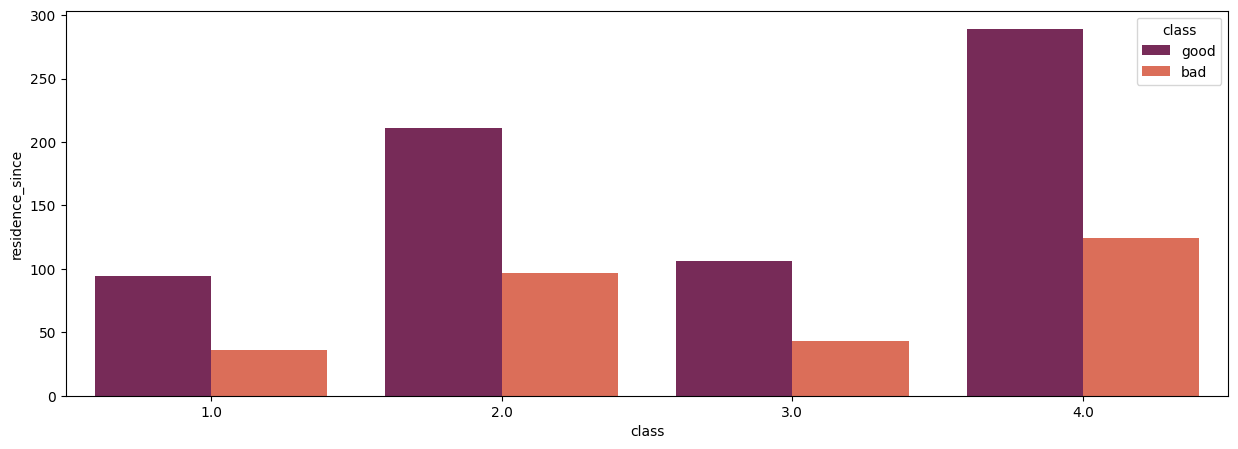

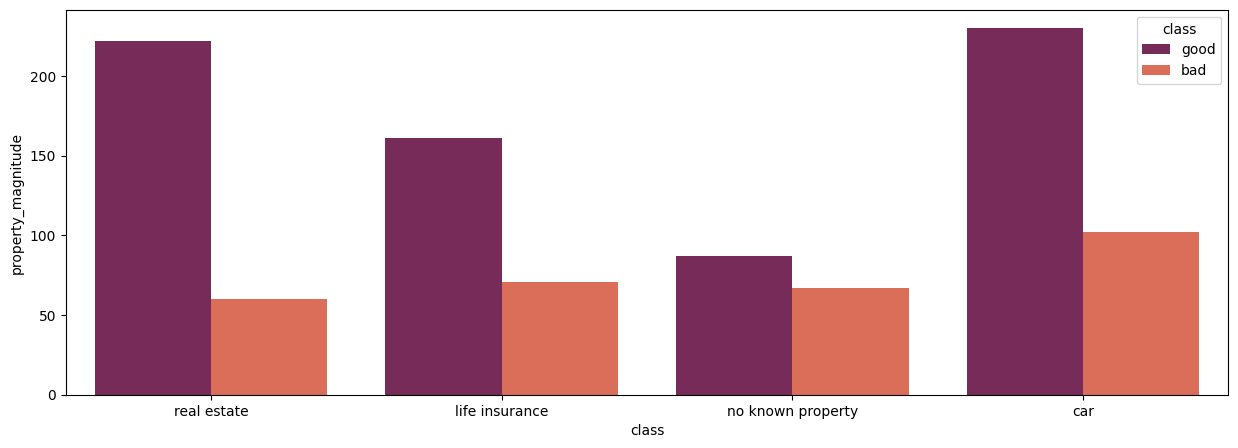

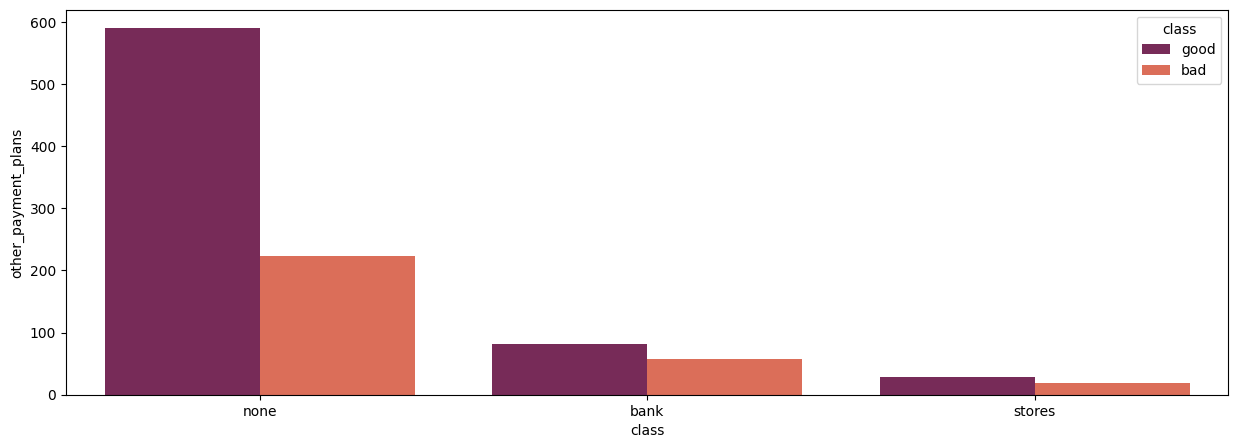

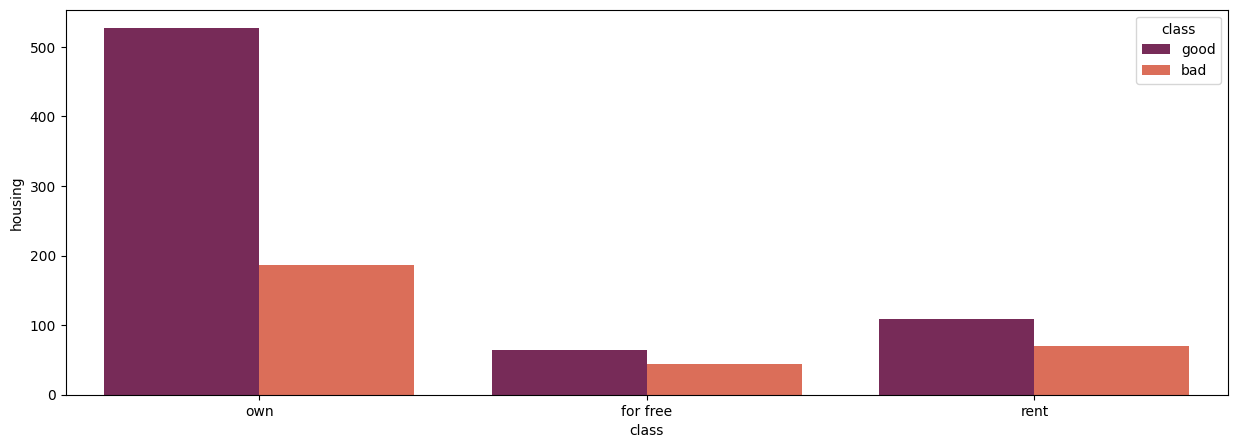

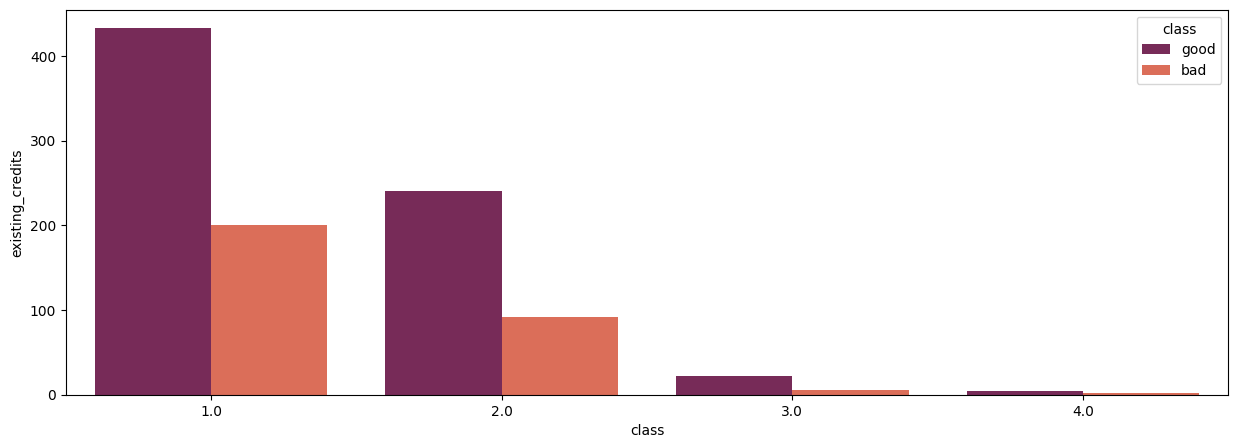

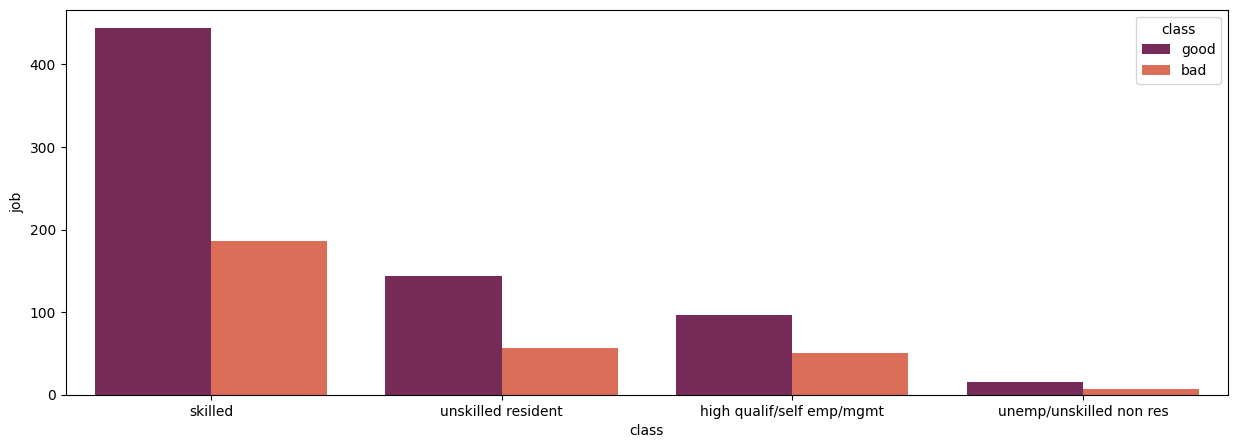

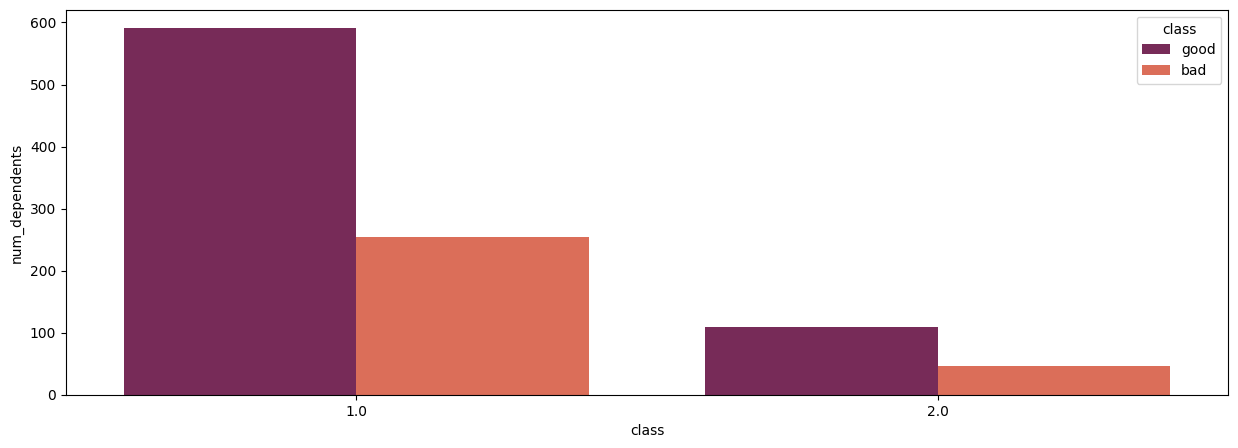

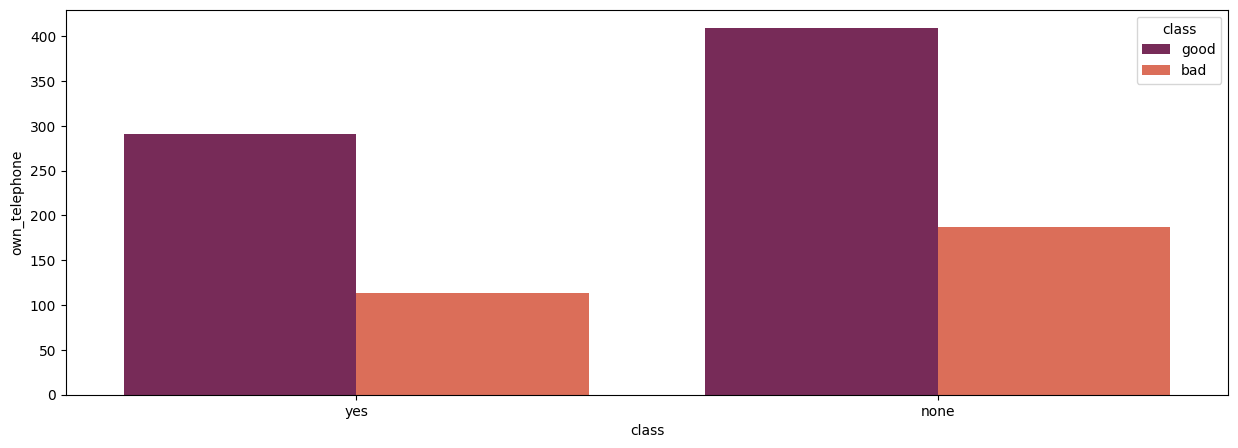

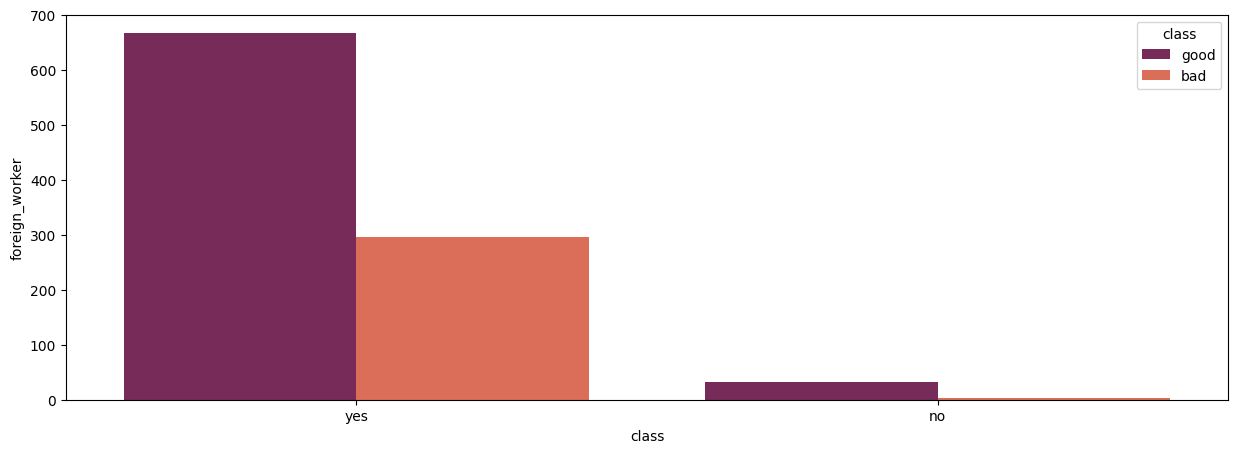

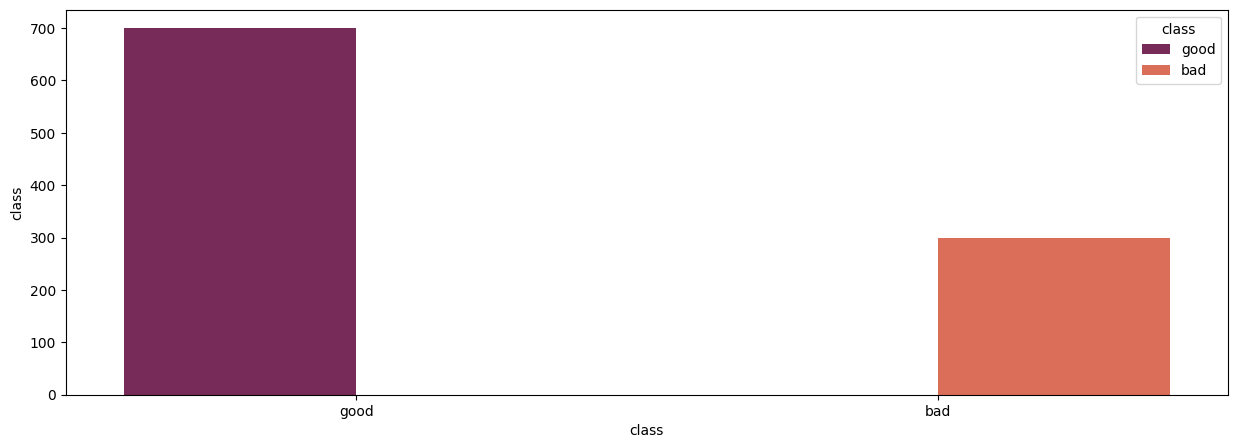

In [21]:
for col in categoricalCols:
    plt.figure(figsize=(15,5))
    ax=sns.countplot(x=col, hue="class", data=df, palette="rocket")
    # Add title and labels
    plt.xlabel(x)
    plt.ylabel(col)
    # Show plot
    plt.show()


**conclusion**

    Class:
      the class distribution is unbalanced 700 good and 300 bad , we need to solve it.
    Forgein worker:
      this featuer is not good to help us in perdiction since the distribution for no forgein worker is so small compare to yes.
    remaings:
      the other distributions is good to can help us to classifiy


# Feature Selection

### Let's apply T-Test and ANOVA Between numerical columns and target coloum
#### Our null hypothesis is there is no correlation or relation between the numerical columns and target one

In [22]:
selectedNumericalFeatuers=[]
significance_level=0.05
numericalColsValuesPValueTTest=[]
numericalColsValuesPValueAnova=[]
numericalColsResult=[]
for col in numericalCols:
  print(f"T-tests and ANOVA tests between {col} and Target")
  group1 = df[df['class'] == "bad"][col]
  group2 = df[df['class'] == "good"][col]
  t_stat, p_value1 = stats.ttest_ind(group1,group2)
  print("T-test results:")
  print("T-statistic:", t_stat)
  print("P-value:", p_value1)
  numericalColsValuesPValueTTest.append(p_value1)
  if  p_value1 < significance_level:
    print(f"The two coloumns {col} and  Target class are correlated ")

  else:
    print(f"The two coloumns {col} and  Target class are not correlated ")


  # Perform one-way ANOVA
  f_stat, p_value2 = f_oneway(group1, group2)
  print("ANOVA results:")
  print("F-statistic:", f_stat)
  print("P-value:", p_value2)
  numericalColsValuesPValueAnova.append(p_value2)
  if  p_value2 < significance_level:
    print(f"The two coloumns {col} and  Target class are correlated ")
  else:
    print(f"The two coloumns {col} and  Target class are not correlated ")

  if p_value1 < significance_level and p_value2 < significance_level:
    selectedNumericalFeatuers.append(col)
    numericalColsResult.append("Accepted")
  else:
    numericalColsResult.append("Not-Accepted")

  print("-----")

T-tests and ANOVA tests between duration and Target
T-test results:
T-statistic: 6.9522507242467215
P-value: 6.4880498771843485e-12
The two coloumns duration and  Target class are correlated 
ANOVA results:
F-statistic: 48.33379013278904
P-value: 6.488049877187189e-12
The two coloumns duration and  Target class are correlated 
-----
T-tests and ANOVA tests between credit_amount and Target
T-test results:
T-statistic: 4.947965832165981
P-value: 8.797572373528893e-07
The two coloumns credit_amount and  Target class are correlated 
ANOVA results:
F-statistic: 24.482365876281996
P-value: 8.797572373533373e-07
The two coloumns credit_amount and  Target class are correlated 
-----
T-tests and ANOVA tests between age and Target
T-test results:
T-statistic: -2.890846677564194
P-value: 0.003925339398276282
The two coloumns age and  Target class are correlated 
ANOVA results:
F-statistic: 8.35699451318393
P-value: 0.003925339398278295
The two coloumns age and  Target class are correlated 
-----


In [23]:
numericalFeatuersTest= pd.DataFrame({"Feature":numericalCols,"Pvalue(Anova)":numericalColsValuesPValueAnova,"Pvalue(T-Test)":numericalColsValuesPValueTTest,"Result":numericalColsResult})
numericalFeatuersTest

,Feature,Pvalue(Anova),Pvalue(T-Test),Result
0,duration,6.488050e-12,6.488050e-12,Accepted
1,credit_amount,8.797572e-07,8.797572e-07,Accepted
2,age,3.925339e-03,3.925339e-03,Accepted


### Let's apply Chi-Squared Between categorical columns and target coloum
#### Our null hypothesis is there is no correlation or relation between the categorical columns and target one

In [24]:
# Create a contingency table from the DataFrame
selectedCategoricalFeatuers=[]
significance_level = 0.05
categoricalColsValuesPValue=[]
categoricalColsResult=[]
for col in categoricalCols:
  print(f"Test Chi-Squared between {col} and target class ")
  contingency_table = pd.crosstab(df[col], df["class"])
  # Run the chi-squared test
  chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
  # Check if the p-value is less than the chosen significance level (e.g., 0.05)
  if col!="class":
      categoricalColsValuesPValue.append(p_val)
  if p_val < significance_level and col!="class":
      print(f"There are reation between the {col} coloum and target class coloum")
      selectedCategoricalFeatuers.append(col)
      categoricalColsResult.append("Accepted")
  elif col!="class":
      print(f"No relation between the {col} coloum and target class coloum ")
      categoricalColsResult.append("Not-Accepted")

  print("P-value:", p_val)
  print("-----")

Test Chi-Squared between checking_status and target class 
There are reation between the checking_status coloum and target class coloum
P-value: 1.2189020722893845e-26
-----
Test Chi-Squared between credit_history and target class 
There are reation between the credit_history coloum and target class coloum
P-value: 1.2791872956750962e-12
-----
Test Chi-Squared between purpose and target class 
There are reation between the purpose coloum and target class coloum
P-value: 0.00011574910079691586
-----
Test Chi-Squared between savings_status and target class 
There are reation between the savings_status coloum and target class coloum
P-value: 2.761214238568249e-07
-----
Test Chi-Squared between employment and target class 
There are reation between the employment coloum and target class coloum
P-value: 0.0010454523491402541
-----
Test Chi-Squared between installment_commitment and target class 
No relation between the installment_commitment coloum and target class coloum 
P-value: 0.140033

In [25]:
categoricalColsTest= pd.DataFrame({"Feature":categoricalCols[:-1],"Pvalue(Chi-Squared)":categoricalColsValuesPValue,"Result":categoricalColsResult})
categoricalColsTest

,Feature,Pvalue(Chi-Squared),Result
0,checking_status,1.218902e-26,Accepted
1,credit_history,1.279187e-12,Accepted
2,purpose,1.157491e-04,Accepted
3,savings_status,2.761214e-07,Accepted
4,employment,1.045452e-03,Accepted
5,installment_commitment,1.400333e-01,Not-Accepted
6,personal_status,2.223801e-02,Accepted
7,other_parties,3.605595e-02,Accepted
8,residence_since,8.615521e-01,Not-Accepted
9,property_magnitude,2.858442e-05,Accepted


**conclusion**

    Numerical Featuers:
      there are correlation between them and target class so we can select them for model training
      they are : ['duration', 'credit_amount', 'age']
    CategoricalFeatuers:
      there are correlation between some featuers and target class so we can select them for model training
      they are:['checking_status','credit_history','purpose','savings_status','employment',
      'installment_commitment',
      'personal_status',
      'property_magnitude',
      'other_payment_plans',
      'housing',
      'foreign_worker',
      'class']
   


In [26]:
selectedNumericalFeatuers

['duration', 'credit_amount', 'age']

In [27]:
selectedCategoricalFeatuers

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'foreign_worker']

In [28]:
selecteddataset=df[selectedCategoricalFeatuers+selectedNumericalFeatuers+["class"]]

In [29]:
selecteddataset.head()

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,foreign_worker,duration,credit_amount,age,class
0,<0,critical/other existing credit,radio/tv,no known savings,>=7,male single,none,real estate,none,own,yes,6.0,1169.0,67.0,good
1,0<=X<200,existing paid,radio/tv,<100,1<=X<4,female div/dep/mar,none,real estate,none,own,yes,48.0,5951.0,22.0,bad
2,no checking,critical/other existing credit,education,<100,4<=X<7,male single,none,real estate,none,own,yes,12.0,2096.0,49.0,good
3,<0,existing paid,furniture/equipment,<100,4<=X<7,male single,guarantor,life insurance,none,for free,yes,42.0,7882.0,45.0,good
4,<0,delayed previously,new car,<100,1<=X<4,male single,none,no known property,none,for free,yes,24.0,4870.0,53.0,bad


# **Data Preprocessing and cleaning**

### Handling missing values

In [30]:
selecteddataset.isna().sum()

checking_status        0
credit_history         0
purpose                0
savings_status         0
employment             0
personal_status        0
other_parties          0
property_magnitude     0
other_payment_plans    0
housing                0
foreign_worker         0
duration               0
credit_amount          0
age                    0
class                  0
dtype: int64

### Handling duplicates

In [31]:
selecteddataset[selecteddataset.duplicated()].sum()

checking_status        0.0
credit_history         0.0
purpose                0.0
savings_status         0.0
employment             0.0
personal_status        0.0
other_parties          0.0
property_magnitude     0.0
other_payment_plans    0.0
housing                0.0
foreign_worker         0.0
duration               0.0
credit_amount          0.0
age                    0.0
class                  0.0
dtype: float64

### Handle Inconsistent Data

In [32]:
 for col in categoricalCols:
  print(df[col].value_counts())
  print("---")

no checking    394
<0             274
0<=X<200       269
>=200           63
Name: checking_status, dtype: int64
---
existing paid                     530
critical/other existing credit    293
delayed previously                 88
all paid                           49
no credits/all paid                40
Name: credit_history, dtype: int64
---
radio/tv               280
new car                234
furniture/equipment    181
used car               103
business                97
education               50
repairs                 22
domestic appliance      12
other                   12
retraining               9
Name: purpose, dtype: int64
---
<100                603
no known savings    183
100<=X<500          103
500<=X<1000          63
>=1000               48
Name: savings_status, dtype: int64
---
1<=X<4        339
>=7           253
4<=X<7        174
<1            172
unemployed     62
Name: employment, dtype: int64
---
4.0    476
2.0    231
3.0    157
1.0    136
Name: installment_commitm

In [33]:
# Initialize the LabelEncoder
labelEncodingCols=["checking_status","credit_history","purpose","personal_status","other_parties","property_magnitude","other_payment_plans","housing","foreign_worker","savings_status","employment",'class']
for col in labelEncodingCols:
  label_encoder = LabelEncoder()
  selecteddataset[col] = label_encoder.fit_transform(selecteddataset[col])


<ipython-input-33-7f1b953aea63>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selecteddataset[col] = label_encoder.fit_transform(selecteddataset[col])
<ipython-input-33-7f1b953aea63>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selecteddataset[col] = label_encoder.fit_transform(selecteddataset[col])
<ipython-input-33-7f1b953aea63>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [34]:
selecteddataset.head()

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,foreign_worker,duration,credit_amount,age,class
0,1,1,6,4,3,3,2,3,1,1,1,6.0,1169.0,67.0,1
1,0,3,6,2,0,0,2,3,1,1,1,48.0,5951.0,22.0,0
2,3,1,2,2,1,3,2,3,1,1,1,12.0,2096.0,49.0,1
3,1,3,3,2,1,3,1,1,1,0,1,42.0,7882.0,45.0,1
4,1,2,4,2,0,3,2,2,1,0,1,24.0,4870.0,53.0,0


### Handling Outliers

In [35]:
numericalCols

['duration', 'credit_amount', 'age']

In [36]:
for col in numericalCols:
  selecteddataset = selecteddataset[~selecteddataset[col].isin(selecteddataset[zscore(selecteddataset[col]) > 3])]


In [37]:
selecteddataset.isna().sum()

checking_status        0
credit_history         0
purpose                0
savings_status         0
employment             0
personal_status        0
other_parties          0
property_magnitude     0
other_payment_plans    0
housing                0
foreign_worker         0
duration               0
credit_amount          0
age                    0
class                  0
dtype: int64

In [38]:
selecteddataset.shape

(1000, 15)

In [39]:
selecteddataset.iloc[0]

checking_status           1.0
credit_history            1.0
purpose                   6.0
savings_status            4.0
employment                3.0
personal_status           3.0
other_parties             2.0
property_magnitude        3.0
other_payment_plans       1.0
housing                   1.0
foreign_worker            1.0
duration                  6.0
credit_amount          1169.0
age                      67.0
class                     1.0
Name: 0, dtype: float64

# Standardization

In [40]:
# Initialize the StandardScaler
scaler = StandardScaler()
# # Standardize the selected numerical columns
selecteddataset[selectedNumericalFeatuers] = scaler.fit_transform(selecteddataset[selectedNumericalFeatuers])

In [41]:
selecteddataset.head()

,checking_status,credit_history,purpose,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,foreign_worker,duration,credit_amount,age,class
0,1,1,6,4,3,3,2,3,1,1,1,-1.236478,-0.745131,2.766456,1
1,0,3,6,2,0,0,2,3,1,1,1,2.248194,0.949817,-1.191404,0
2,3,1,2,2,1,3,2,3,1,1,1,-0.738668,-0.416562,1.183312,1
3,1,3,3,2,1,3,1,1,1,0,1,1.750384,1.634247,0.831502,1
4,1,2,4,2,0,3,2,2,1,0,1,0.256953,0.566664,1.535122,0


In [42]:
selecteddataset.columns

Index(['checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'foreign_worker', 'duration',
       'credit_amount', 'age', 'class'],
      dtype='object')

In [43]:
# Separate Target Variable and Predictor Variables
TargetVariable='class'
Predictors=[ 'age','checking_status', 'credit_history', 'purpose', 'savings_status',
       'employment', 'personal_status', 'other_parties', 'property_magnitude',
       'other_payment_plans', 'housing', 'foreign_worker', 'credit_amount',
       'duration']

X=selecteddataset[Predictors].values
y=selecteddataset[TargetVariable].values

## Spliting Data

In [44]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 14)
(800,)
(200, 14)
(200,)


# Apply BaseLine Model

### Apply GridSearch to get the best parameters for the model

In [46]:
parameters = {'C': [0.1, 1, 10, 100]}
# Initialize the logistic regression model
log_reg = LogisticRegression()
# Use GridSearchCV for hyperparameter tuning
clf = GridSearchCV(log_reg, parameters, cv=5)
clf.fit(X_train, y_train)
# Print the model parameters
print(f"The model parameters:{clf.best_params_}")

The model parameters:{'C': 0.1}


### Define the model

In [47]:
baseModel=LogisticRegression(**clf.best_params_)
baseModel

LogisticRegression(C=0.1)

### Evaluate  the model

In [48]:
baseModel.fit(X_train,y_train)

LogisticRegression(C=0.1)

In [49]:
baseModelTestPrediction = baseModel.predict(X_test)
baseModelTrainPrediction = baseModel.predict(X_train)
baseModelTestCm = confusion_matrix(y_test, baseModelTestPrediction)
baseModelTrainCm = confusion_matrix(y_train, baseModelTrainPrediction)

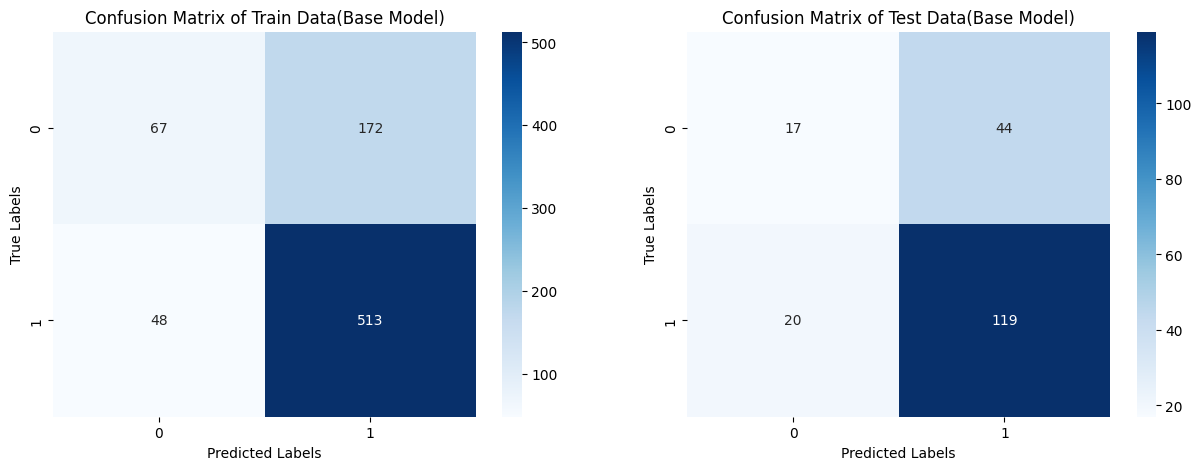

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(baseModelTrainCm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix of Train Data(Base Model)')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Plot confusion matrix for test data
sns.heatmap(baseModelTestCm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix of Test Data(Base Model)')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.show()

In [51]:
print("Classification Report of Train Data (Base Model):")
print(classification_report(y_train, baseModelTrainPrediction))
print("Classification Report of Test Data (Base Model):")
print(classification_report(y_test, baseModelTestPrediction))

Classification Report of Train Data (Base Model):
              precision    recall  f1-score   support

           0       0.58      0.28      0.38       239
           1       0.75      0.91      0.82       561

    accuracy                           0.73       800
   macro avg       0.67      0.60      0.60       800
weighted avg       0.70      0.72      0.69       800

Classification Report of Test Data (Base Model):
              precision    recall  f1-score   support

           0       0.46      0.28      0.35        61
           1       0.73      0.86      0.79       139

    accuracy                           0.68       200
   macro avg       0.59      0.57      0.57       200
weighted avg       0.65      0.68      0.65       200



### Cost Matrix

In [52]:
goodPredictedBadTrain=baseModelTrainCm[1][0]
badPredictedGoodTrain=baseModelTrainCm[0][1]
goodPredictedBadTest=baseModelTestCm[1][0]
badPredictedGoodTest=baseModelTestCm[0][1]
trainScore=badPredictedGoodTrain*5+goodPredictedBadTrain
testScore=badPredictedGoodTest*5+goodPredictedBadTest
data = {'Dataset': ["Train","Test"],
        'CostScore(BaseModel)': [trainScore,testScore]}
baseModelDf = pd.DataFrame(data)
baseModelDf

,Dataset,CostScore(BaseModel)
0,Train,908
1,Test,240


# Apply PCA before Base Model

## **Take the hole data as input features for the pca this will help us to handle the problem of unbalanced class by generated new feature**

In [53]:
X_train, X_test, y_train, y_test = train_test_split(selecteddataset, selecteddataset["class"], test_size=0.2)

## Get the number of components

In [54]:
# Create a pipeline with StandardScaler, PCA, and LogisticRegression
pipe = Pipeline([('pca', PCA()), ('log', baseModel)])
# Set the parameters to be tuned
parameters = {'pca__n_components': [2,4,5,6]}
# Use GridSearchCV for hyperparameter tuning
clf = GridSearchCV(pipe, parameters, cv=5)
clf.fit(X_train, y_train)
# Print the model parameters
print(f"The model parameters:{clf.best_params_}")

The model parameters:{'pca__n_components': 4}


## Define the Full pipe

In [55]:
pca=PCA(n_components=clf.best_params_['pca__n_components'])

In [56]:
pcaModel = Pipeline([('pca', pca), ('log', baseModel)])

In [57]:
pcaModel.fit(X_train,y_train)

Pipeline(steps=[('pca', PCA(n_components=4)),
                ('log', LogisticRegression(C=0.1))])

## Evalaution

In [58]:
pcaModelTestPrediction = pcaModel.predict(X_test)
pcaModelTrainPrediction = pcaModel.predict(X_train)
pcaModelTestCm = confusion_matrix(y_test, pcaModelTestPrediction)
pcaModelTrainCm = confusion_matrix(y_train, pcaModelTrainPrediction)

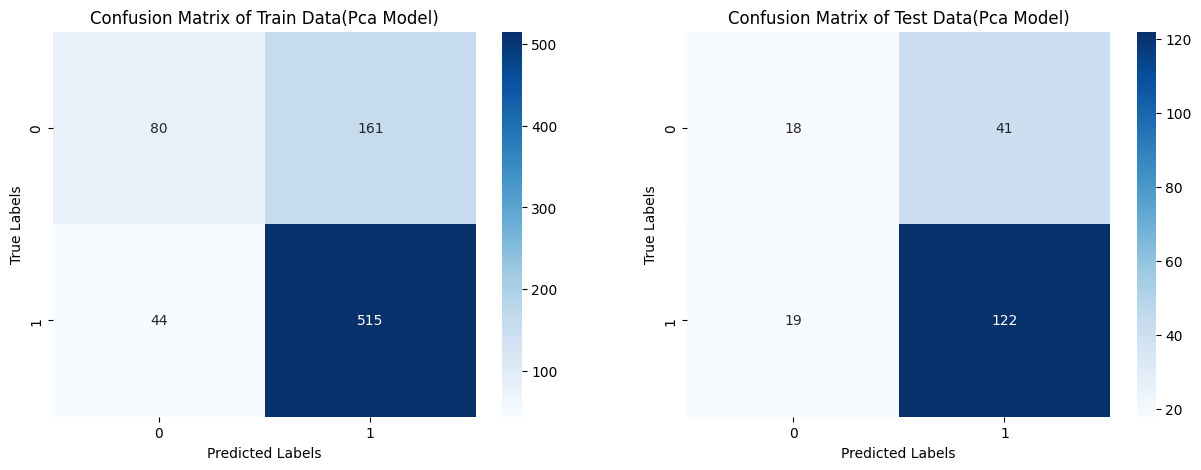

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pcaModelTrainCm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix of Train Data(Pca Model)')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Plot confusion matrix for test data
sns.heatmap(pcaModelTestCm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix of Test Data(Pca Model)')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.show()

In [60]:
print("Classification Report of Train Data (Pca Model):")
print(classification_report(y_train, pcaModelTrainPrediction))
print("Classification Report of Test Data (Pca Model):")
print(classification_report(y_test, pcaModelTestPrediction))

Classification Report of Train Data (Pca Model):
              precision    recall  f1-score   support

           0       0.65      0.33      0.44       241
           1       0.76      0.92      0.83       559

    accuracy                           0.74       800
   macro avg       0.70      0.63      0.64       800
weighted avg       0.73      0.74      0.71       800

Classification Report of Test Data (Pca Model):
              precision    recall  f1-score   support

           0       0.49      0.31      0.38        59
           1       0.75      0.87      0.80       141

    accuracy                           0.70       200
   macro avg       0.62      0.59      0.59       200
weighted avg       0.67      0.70      0.68       200



## Cost Matrix

In [61]:
goodPredictedBadTrain=pcaModelTrainCm[1][0]
badPredictedGoodTrain=pcaModelTrainCm[0][1]
goodPredictedBadTest=pcaModelTestCm[1][0]
badPredictedGoodTest=pcaModelTestCm[0][1]
trainScore=badPredictedGoodTrain*5+goodPredictedBadTrain
testScore=badPredictedGoodTest*5+goodPredictedBadTest
data = {'Dataset': ["Train","Test"],
        'CostScore(pcaModel)': [trainScore,testScore]}
pipeDf = pd.DataFrame(data)
pipeDf

,Dataset,CostScore(pcaModel)
0,Train,849
1,Test,224


# Compare between the models

In [85]:
 combinedDataframe=pd.merge(baseModelDf, pipeDf, on='Dataset')
 combinedDataframe

,Dataset,CostScore(BaseModel),CostScore(pcaModel)
0,Train,908,849
1,Test,240,224


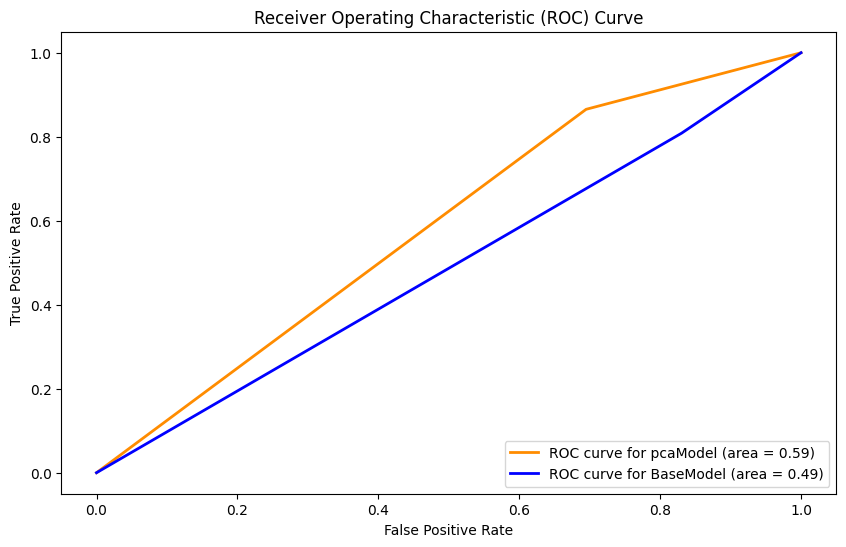

In [63]:
# Calculate the false positive rate, true positive rate, and thresholds
fprpca, tprpca, thresholdspca = roc_curve(y_test, pcaModelTestPrediction)
fprBase, tprBase, thresholdsBase = roc_curve(y_test, baseModelTestPrediction)
# Calculate the AUC (Area Under the Curve)
aucpca = roc_auc_score(y_test, pcaModelTestPrediction)
aucBase = roc_auc_score(y_test, baseModelTestPrediction)
# Visualize the ROC curve using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(fprpca, tprpca, color='darkorange', lw=2, label=f'ROC curve for pcaModel (area = {aucpca:.2f})')
plt.plot(fprBase, tprBase, color='blue', lw=2, label=f'ROC curve for BaseModel (area = {aucBase:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Let's apply AutoEncoder to can get best features

## **Take the hole data as input features for the autoencoder this will help us to handle the problem of unbalanced class by generated new feature**

In [86]:
X_train, X_test, y_train, y_test = train_test_split(selecteddataset, selecteddataset["class"], test_size=0.2)

## Train Autoencoder architecture

In [87]:
input_dim = X_train.shape[1]
# Define the input layer
input_layer = keras.layers.Input(shape=(input_dim,))
# Define the encoder layers with dropout
encoder = keras.layers.Dense(5, activation='relu')(input_layer)
encoder = keras.layers.Dropout(0.1)(encoder)
# Define the decoder layers
decoder = keras.layers.Dense(input_dim, activation='sigmoid')(encoder)
# Create the autoencoder model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoder)
# # Compile the model
autoencoder.compile(optimizer='adam', loss='mse')
# # Train the autoencoder
autoencoder.fit(selecteddataset, selecteddataset, epochs=100, batch_size=16)


Epoch 1/100
63/63 [==============================] - 3s 24ms/step - loss: 3.2276
Epoch 2/100
63/63 [==============================] - 0s 3ms/step - loss: 3.1031
Epoch 3/100
63/63 [==============================] - 0s 4ms/step - loss: 2.9164
Epoch 4/100
63/63 [==============================] - 2s 37ms/step - loss: 2.7330
Epoch 5/100
63/63 [==============================] - 0s 3ms/step - loss: 2.5701
Epoch 6/100
63/63 [==============================] - 0s 3ms/step - loss: 2.4741
Epoch 7/100
63/63 [==============================] - 0s 3ms/step - loss: 2.4443
Epoch 8/100
63/63 [==============================] - 2s 25ms/step - loss: 2.4279
Epoch 9/100
63/63 [==============================] - 1s 18ms/step - loss: 2.4206
Epoch 10/100
63/63 [==============================] - 1s 17ms/step - loss: 2.4178
Epoch 11/100
63/63 [==============================] - 2s 33ms/step - loss: 2.4109
Epoch 12/100
63/63 [==============================] - 1s 20ms/step - loss: 2.4150
Epoch 13/100
63/63 [==========

### Extract the encoder part and generate new featuers

In [88]:
encoderModel = keras.models.Model(inputs=input_layer, outputs=encoder)
# # Use the encoder model for further analysis
trainFeatures = encoderModel.predict(X_train)
testFeatures = encoderModel.predict(X_test)

7/7 [==============================] - 0s 2ms/step


In [89]:
# Fit the pipeline
baseModel.fit(trainFeatures, y_train)

LogisticRegression(C=0.1)

## Evalute The model

In [90]:
# Predict customer churn
trainAutoEncoderModelpredictions = baseModel.predict(trainFeatures)
testAutoEncoderModelpredictions = baseModel.predict(testFeatures)
# Generate the classification report
print(classification_report(y_train, trainAutoEncoderModelpredictions))
print(classification_report(y_test, testAutoEncoderModelpredictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1       1.00      1.00      1.00       556

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00       144

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [91]:
trainAutoEncoderModelCm = confusion_matrix(y_train, trainAutoEncoderModelpredictions)
testAutoEncoderModelCm = confusion_matrix(y_test, testAutoEncoderModelpredictions)

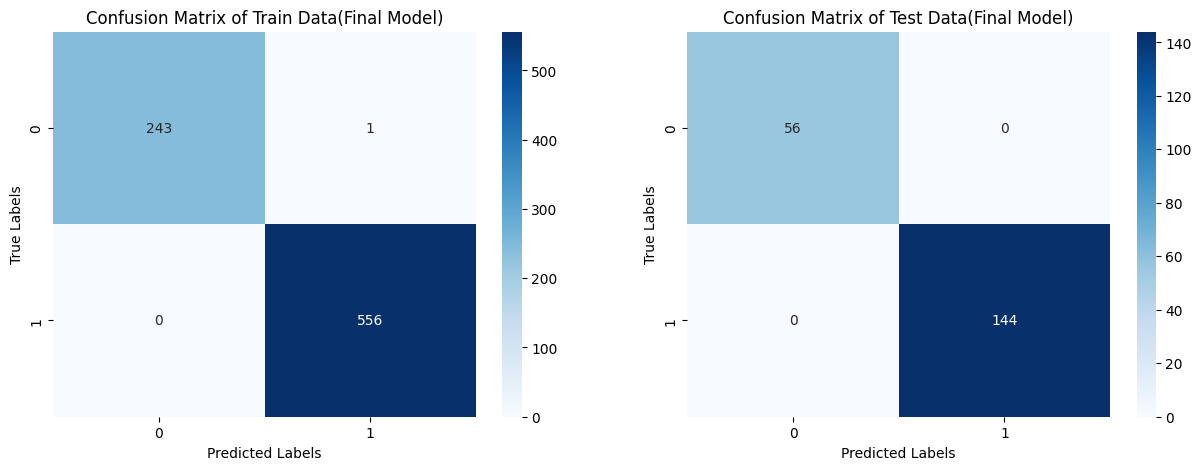

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(trainAutoEncoderModelCm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix of Train Data(Final Model)')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Plot confusion matrix for test data
sns.heatmap(testAutoEncoderModelCm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix of Test Data(Final Model)')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.show()

## Cost Matrix

In [93]:
goodPredictedBadTrain=trainAutoEncoderModelCm[1][0]
print(goodPredictedBadTrain)
badPredictedGoodTrain=trainAutoEncoderModelCm[0][1]
goodPredictedBadTest=testAutoEncoderModelCm[1][0]
badPredictedGoodTest=testAutoEncoderModelCm[0][1]
trainScore=badPredictedGoodTrain*5+goodPredictedBadTrain
testScore=badPredictedGoodTest*5+goodPredictedBadTest
data = {'Dataset': ["Train","Test"],
        'CostScore(AutoEncoderModel)': [trainScore,testScore]}
AutoEncoderModelDf = pd.DataFrame(data)
AutoEncoderModelDf

0


,Dataset,CostScore(AutoEncoderModel)
0,Train,5
1,Test,0


## Compare the models

In [94]:
combinedDataframe=pd.merge(combinedDataframe, AutoEncoderModelDf, on='Dataset')

In [95]:
sum_row = {col: combinedDataframe[col].sum() if col != 'Dataset' else 'sum' for col in combinedDataframe.columns}
combinedDataframe = combinedDataframe.append(sum_row, ignore_index=True)
combinedDataframe = combinedDataframe.set_index('Dataset').T.reset_index()
# Renaming the columns
combinedDataframe.columns = ['Model', 'Train', 'Test', 'sum']
combinedDataframe

,Model,Train,Test,sum
0,CostScore(BaseModel),908,240,1148
1,CostScore(pcaModel),849,224,1073
2,CostScore(AutoEncoderModel),5,0,5


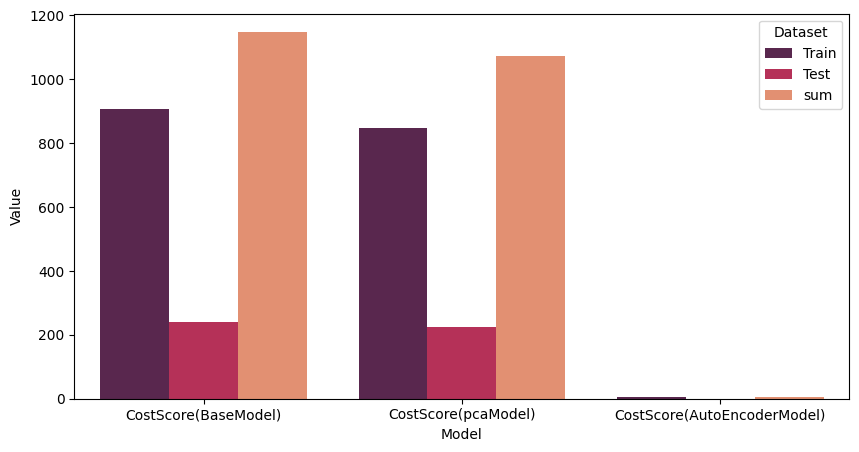

In [96]:
# Melt the DataFrame to long format
melted = combinedDataframe.melt(id_vars='Model', var_name='Dataset', value_name='Value')
# Plotting the data
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Value', hue='Dataset', data=melted,palette="rocket")
plt.show()


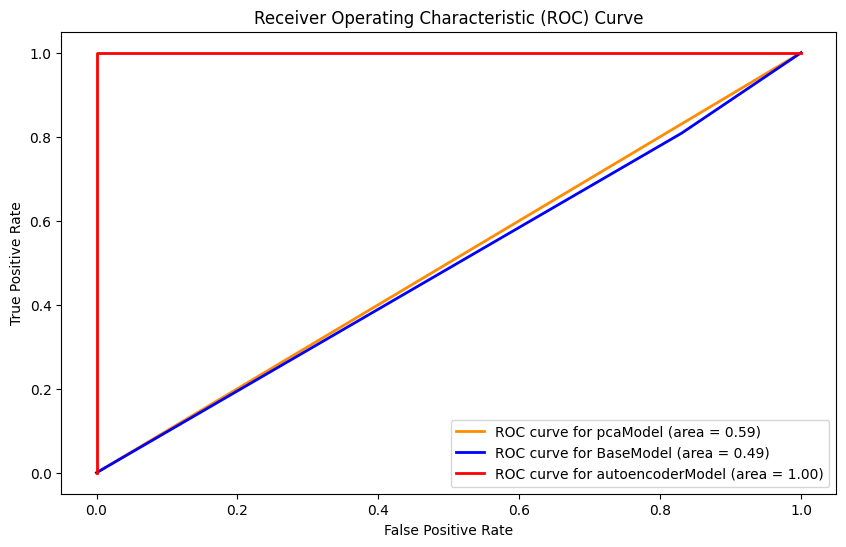

In [97]:
# Calculate the false positive rate, true positive rate, and thresholds
fprAutoEncoderModel, tprAutoEncoderModel, thresholdsAutoEncoderModel = roc_curve(y_test, testAutoEncoderModelpredictions)
# Calculate the AUC (Area Under the Curve)
aucAutoEncoderModel = roc_auc_score(y_test, testAutoEncoderModelpredictions)
# Visualize the ROC curve using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(fprpca, fprpca, color='darkorange', lw=2, label=f'ROC curve for pcaModel (area = {aucpca:.2f})')
plt.plot(fprBase, tprBase, color='blue', lw=2, label=f'ROC curve for BaseModel (area = {aucBase:.2f})')
plt.plot(fprAutoEncoderModel, tprAutoEncoderModel, color='red', lw=2, label=f'ROC curve for autoencoderModel (area = {aucAutoEncoderModel:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()